In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notas generales de Sentiment Analysis

## Introducción

Introducción al tema...

## Problemas a tener en cuenta

* En los reviews de productos suele haber una tendencia al sesgo de los comentarios positivos (p 100 P&L)

* P&L recomiendan extraer las frases subjetivas y no incluir las objetivas pero yo creo que eso es hacer un poco de trampa.

* Una posibilidad es seleccionar por tópicos o tipos de productos

* Podría considerarse el problema de resumen de sentimientos, además de la categorización, y para eso usar el título del review.

* Considerar diferentes momentos para obtener los reviews [ver](https://www.aaai.org/Papers/Symposia/Spring/2004/SS-04-07/SS04-07-003.pdf) 


## TO DO list:

* Armar el datasheet del dataset MeLiSA e ir definiendo las características del mismo a partir de éste. Para eso, sería recomendable leer P&L, el paper de IMDb y el paper de datasheets for datasets

* Ver la [clase de sesgos en NLP](https://www.youtube.com/watch?v=XR8YSRcuVLE&feature=youtu.be) y las de evaluation metrics [1](https://youtu.be/3UGti9Ju5j8) y [2](https://youtu.be/YygGzfkhtJc) y estudiarlas bien bien.

* Analizar los posibles sesgos del dataset y modificar el datasheet del primer punto hasta que quede bien armado.

* Ir armando el paper. Tratar de separar las tareas para darle cosas para hacer a Mati y a Leo.

# Resumen cap 3, 4 y 5 de Pang & Lee

## Capítulo 3: Desafíos generales

El capítulo habla de por qué las tarea de clasificación de sentimientos es distinta a la de clasificación de texto en general. Se argumenta que extraer palabras relacionadas con el significado o la connotación (positiva o negativa) no es un gran indicativo de si el documento pertenece a una categoría determinada, debido a que los sentimientos pueden expresarse de manera mucho más sutil que simplemente explicitando una palabra clave y a que las oraciones suelen ser muy dependientes del contexto. Además el orden en que se dicen las cosas importan mucho.

Como ejercicio podemos probar clasificar texto con NaiveBayes+BOW y con LogisticRegression+BODocs:

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import torch

# Utilizo el dataset IMDb
ds, ds_info = tfds.load('imdb_reviews',
                        split=None, # Descargo todos los splits
                        download=True, # Si no está descargado, que se descargue
                        with_info=True, # Quiero que devuelva info del dataset
                       )

# Decodifico a dataframes con strings comunes
df_train = tfds.as_dataframe(ds['train'], ds_info)
df_train['text'] = df_train['text'].str.decode('utf-8')
df_test = tfds.as_dataframe(ds['test'], ds_info)
df_test['text'] = df_test['text'].str.decode('utf-8')

# Divido en train, val, test 
random_seed = 16254872
rs = np.random.RandomState(random_seed)
val_size = .1
mask = rs.rand(len(df_train)) < val_size
df_val = df_train[mask].copy().reset_index(drop=True)
df_train = df_train[~mask].copy().reset_index(drop=True)

# Tokenizo
df_train['text'] = df_train['text'].str.findall(r'[a-zA-Z0-9]+')
df_val['text'] = df_val['text'].str.findall(r'[a-zA-Z0-9]+')
df_test['text'] = df_test['text'].str.findall(r'[a-zA-Z0-9]+')

# Obtengo el vocabulario
vocab = df_train['text'].explode().value_counts()

In [4]:
print('Cantidad de palabras:',len(vocab))

Cantidad de palabras: 89356


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from nlp_feature_extraction import BONgramsVectorizer
import time

# Vectorizo los sets de train, val y test
tic = time.time()
vec = CountVectorizer(analyzer= lambda x: x, vocabulary=vocab.index.tolist()[2:50000])
X_train = vec.fit_transform(df_train['text'])
X_val = vec.transform(df_val['text'])
X_test = vec.transform(df_test['text'])
toc = time.time()
print('Vectorizer sklearn:',toc - tic)

tic = time.time()
vec2 = BONgramsVectorizer(tokenizer=None,min_count=0,
                max_count=None,max_words=50000,ngram_range=(1,1))
X_train2 = vec2.fit_transform(df_train['text'])
X_val2 = vec2.transform(df_val['text'])
X_test2 = vec2.transform(df_test['text'])
toc = time.time()
print('Vectorizer sklearn:',toc - tic)

y_train = df_train['label'].values.astype(np.float)
y_val = df_val['label'].values.astype(np.float)
y_test = df_test['label'].values.astype(np.float)

100%|██████████| 22549/22549 [00:07<00:00, 2913.36it/s]
Vectorizer sklearn: 19.097321271896362


Entrenamiento por Naive Bayes:

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

clf = MultinomialNB(alpha=.2)
clf.fit(X_train,y_train)
y_val_pred = clf.predict(X_val)
val_score = f1_score(y_val,y_val_pred, average='macro')
print('F1-score con Naive Bayes sobre development: {:.4f}'.format(val_score))

F1-score con Naive Bayes sobre development: 0.8432


In [6]:
y_test_pred = clf.predict(X_test)
test_score = f1_score(y_test,y_test_pred, average='macro')
print('F1-score con Naive Bayes sobre test: {:.4f}'.format(test_score))

F1-score con Naive Bayes sobre test: 0.8068


Entrenamiento por Logistic Regression:

In [13]:
import luthiertext
from luthiertext.word_vectors import WordByCategoryVectorizer

y_train = df_train['label'].values.astype(np.float)
y_val = df_val['label'].values.astype(np.float)
y_test = df_test['label'].values.astype(np.float)

vec = WordByCategoryVectorizer(tokenizer=lambda x: x, min_count=0.,
                                max_count=None, max_words=None, unk_token=None)
vec.train(df_train['text'],y_train)
X_train = vec.vectorize_corpus(df_train['text'])
X_val = vec.vectorize_corpus(df_val['text'])
X_test = vec.vectorize_corpus(df_test['text'])

100%|██████████| 25000/25000 [00:14<00:00, 1775.66it/s]



            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 2.57322e+06. Epochs 0/1. Batch 0/353.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 2.8482e+06. Epochs 0/1. Batch 100/353.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 1.14966e+07. Epochs 0/1. Batch 200/353.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 9.37895e+06. Epochs 0/1. Batch 300/353.
            


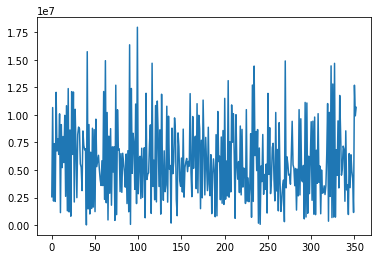

In [20]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


class IMDbDataset(Dataset):

    def __init__(self,X,y):
        self.X = torch.from_numpy(X).type(torch.float)
        self.y = torch.from_numpy(y).type(torch.float)

    def __getitem__(self,idx):
        return self.X[idx,:].view(-1),self.y[idx].view(-1)

    def __len__(self):
        return len(self.y)


train_dataset = IMDbDataset(X_train,y_train)
val_dataset = IMDbDataset(X_val,y_val)
test_dataset = IMDbDataset(X_test,y_test)

batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)


# class LogisticRegressionClassifier(nn.Module):

#     def __init__(self,in_features,n_hidden,bias=True):
#         super().__init__()
#         self.linear = nn.Linear(in_features,n_hidden,bias=bias)
#         self.hidden = nn.Linear(n_hidden,1,bias=bias)

#     def forward(self,x):
#         logits = self.hidden(torch.relu(self.linear(x)))
#         return logits

class LogisticRegressionClassifier(nn.Module):

    def __init__(self,in_features,bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features,1,bias=bias)

    def forward(self,x):
        logits = self.linear(x)
        return logits


epochs = 1
in_features = int(max(y_train)+1)
n_hidden = 20
#model = LogisticRegressionClassifier(in_features,n_hidden,bias=True)
model = LogisticRegressionClassifier(in_features,bias=True)
loss_fn = nn.BCEWithLogitsLoss()
loss_history = []
learning_rate = 1e-6
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
for e in range(epochs):
    for i, (x, y) in enumerate(train_dataloader):

        optim.zero_grad()

        logits = model(x)
        loss = loss_fn(logits,y)
        loss.backward()
        optim.step()
        
        loss_history.append(loss)

        if i % 100 == 0:
            print("""
            Accuracy on train: {}
            Accuracy on val: {}
            Loss value: {:4g}. Epochs {}/{}. Batch {}/{}.
            """.format(0,0,loss,e,epochs,i,len(train_dataloader)))
        

import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [21]:
def predict(dataset,model):

    model.eval()

    n_samples = len(dataset)
    y_predict = torch.zeros(n_samples,dtype=torch.long)
    with torch.no_grad():
        for i in range(n_samples):
            x, _ = dataset[i]
            scores = model(x)
            y_predict[i] = (scores > 0).type(torch.long)

    return y_predict

from sklearn.metrics import f1_score

y_val_predict = predict(train_dataset,model)
val_score = f1_score(y_train,y_val_predict, average='macro')
print('F1-score con 2-layer net sobre development: {:.4f}'.format(val_score))

F1-score con 2-layer net sobre development: 0.3335


In [22]:
samples, labels = zip(*[train_dataset[i] for i in range(len(train_dataset))])

samples = torch.stack(samples,dim=0)
labels = torch.stack(labels,dim=0)

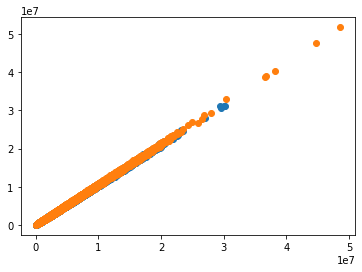

In [23]:
fig, ax = plt.subplots()
ax.plot(samples[(labels==0).view(-1),0],samples[(labels==0).view(-1),1],'o')
ax.plot(samples[(labels==1).view(-1),0],samples[(labels==1).view(-1),1],'o')